# Solve for x_i (Poverty Probability) from RWI Values

This notebook solves for x_i (poverty probability per cell) from RWI values using constraint equations.

Given:
$$RWI_i = \frac{x_i - \mu}{\sigma}$$

Therefore:
$$x_i = \sigma \times RWI_i + \mu$$

**Constraints:**
$$\sum(x_i \times t_i) = P_j \times \sum(t_i) \space \text{for each subset }j$$

Where:
- $t_i$ = children_population in cell $i$
- $P_j$ = poverty rate for subset $j$ (Rural, Urban, or KMA)

This script solves for $\sigma$ (sigma) and $\mu$ (mu) using least squares on the constraint equations.

## Imports

In [1]:
import os
import numpy as np
import geopandas as gpd
import math 

## Configuration, Loading, & Classification

In [2]:
BASE_DIR = "data"
COUNTRY = "JAM"

# Poverty rates by classification (as proportions)
POVERTY_RATE_RURAL = 34.6460305820465 / 100.0
POVERTY_RATE_URBAN = 22.9166205159144 / 100.0
POVERTY_RATE_KMA = 34.5674892972073 / 100.0

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

# Output file
OUTPUT_FILE = "analysis_output/tiles_with_x_i.parquet"

### Load data

In [3]:
# Construct file paths
# Base admin boundaries file
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")

# Base tile file (14-level tiles with population and RWI)
tiles_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", f"{COUNTRY}_14.parquet")

print(f"Loading data files...")
print(f"  Admin boundaries: {admin_base_path}")
print(f"  Tiles: {tiles_base_path}")

# Load base admin boundaries
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
    print(f"   Columns: {list(gdf_admin.columns)}")
else:
    raise FileNotFoundError(f"Admin boundaries file not found: {admin_base_path}")

# Load base tiles with population and RWI
if os.path.exists(tiles_base_path):
    gdf_tiles = gpd.read_parquet(tiles_base_path)
    print(f"\nLoaded tiles: {len(gdf_tiles)} cells")
    print(f"   Columns: {list(gdf_tiles.columns)}")
else:
    raise FileNotFoundError(f"Tiles file not found: {tiles_base_path}")

Loading data files...
  Admin boundaries: data/geodb/aos_views/admin_views/JAM_admin1.parquet
  Tiles: data/geodb/aos_views/mercator_views/JAM_14.parquet

Loaded admin boundaries: 14 parishes
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'built_surface_m2', 'population', 'num_schools', 'num_hcs', 'smod_class', 'rwi', 'name', 'geometry']

Loaded tiles: 2231 cells
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id']


### Helper functions

In [4]:
def classify_area(parish, smod_class):
    """Classify area as Rural, Urban, or KMA."""
    import math
    
    if parish in KMA_PARISHES:
        return "KMA"
    elif smod_class is None or math.isnan(smod_class):
        return "Rural"  # Default to rural if SMOD is missing
    elif smod_class >= SMOD_URBAN_THRESHOLD:
        return "Urban"
    else:
        return "Rural"


def subset_sums(rwi_values, population_values, subset_indices):
    """
    Calculate weighted sums for a subset.
    
    Parameters:
    -----------
    rwi_values : array-like
        RWI values for all cells
    population_values : array-like
        Population (children) values for all cells
    subset_indices : array-like
        Indices of cells in this subset
    
    Returns:
    --------
    W : float
        sum(RWI_i * t_i) for subset
    T : float
        sum(t_i) for subset
    """
    W = np.sum(rwi_values[subset_indices] * population_values[subset_indices])
    T = np.sum(population_values[subset_indices])
    return W, T

### Prepare tile data

In [5]:
# Identify the correct column names
# Try to find RWI column
rwi_column = None
for col in gdf_tiles.columns:
    if col.lower() == 'rwi' or col.lower() == 'relative_wealth_index':
        rwi_column = col
        break

if rwi_column is None:
    rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
    if rwi_cols:
        rwi_column = rwi_cols[0]

# Try to find children population columns (0-5 and 5-15)
infant_col = None
school_age_col = None
for col in gdf_tiles.columns:
    if 'infant' in col.lower() or '0-5' in col.lower():
        infant_col = col
    if 'school_age' in col.lower() or '5-15' in col.lower():
        school_age_col = col

# Try to find tile_id column
tile_id_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['tile_id', 'tileid', 'id', 'zone_id']:
        tile_id_column = col
        break

print(f"Identified columns:")
print(f"  RWI column: {rwi_column}")
print(f"  Infant population (0-5): {infant_col}")
print(f"  School age population (5-15): {school_age_col}")
print(f"  Tile ID column: {tile_id_column}")

if rwi_column is None:
    print("\nWarning: Could not find RWI column")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required column (RWI) not found")

if infant_col is None or school_age_col is None:
    print("\nWarning: Could not find children population columns")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required columns (infant_population and school_age_population) not found")

# Create a working copy of tiles
gdf_work = gdf_tiles.copy()

# Ensure we have the necessary columns with standardized names
gdf_work['rwi'] = gdf_work[rwi_column]
gdf_work['infant_population'] = gdf_work[infant_col].fillna(0)
gdf_work['school_age_population'] = gdf_work[school_age_col].fillna(0)
gdf_work['children_population'] = gdf_work['infant_population'] + gdf_work['school_age_population']

if tile_id_column:
    gdf_work['tile_id'] = gdf_work[tile_id_column]
else:
    gdf_work['tile_id'] = gdf_work.index

# Remove rows with missing RWI or zero children population
gdf_work = gdf_work[gdf_work['rwi'].notna() & (gdf_work['children_population'] > 0)].copy()

print(f"\nPrepared {len(gdf_work)} tiles with valid RWI and children population data")
print(f"  Total children population: {gdf_work['children_population'].sum():,.0f}")
print(f"  - Ages 0-5: {gdf_work['infant_population'].sum():,.0f}")
print(f"  - Ages 5-15: {gdf_work['school_age_population'].sum():,.0f}")


Identified columns:
  RWI column: rwi
  Infant population (0-5): infant_population
  School age population (5-15): school_age_population
  Tile ID column: tile_id

Prepared 2224 tiles with valid RWI and children population data
  Total children population: 845,814
  - Ages 0-5: 217,525
  - Ages 5-15: 628,289


### Assign tiles to parishes & classify 

In [6]:
# Perform spatial join to assign each tile to a parish
# Ensure both GeoDataFrames have the same CRS
if gdf_work.crs != gdf_admin.crs:
    gdf_work = gdf_work.to_crs(gdf_admin.crs)

# Start with a copy of all original tiles - we will assign parishes one by one
# This ensures we never lose any tiles
gdf_tiles_with_admin = gdf_work.copy()
gdf_tiles_with_admin['parish'] = None

print(f"Assigning {len(gdf_tiles_with_admin)} tiles to parishes...")

# For each tile, determine its parish assignment
for idx, tile_row in gdf_tiles_with_admin.iterrows():
    tile_geom = tile_row.geometry
    tile_centroid = tile_geom.centroid
    assigned_parish = None
    
    # Step 1: Check if tile intersects any parish
    intersecting_parishes = []
    for admin_idx, admin_row in gdf_admin.iterrows():
        if tile_geom.intersects(admin_row.geometry):
            intersecting_parishes.append(admin_row['name'])
    
    if len(intersecting_parishes) == 1:
        # Tile intersects exactly one parish - assign to it
        assigned_parish = intersecting_parishes[0]
    elif len(intersecting_parishes) > 1:
        # Tile intersects multiple parishes - use centroid to decide
        centroid_gdf = gpd.GeoDataFrame([{'geometry': tile_centroid}], crs=gdf_admin.crs)
        centroid_join = gpd.sjoin(centroid_gdf, gdf_admin[['name', 'geometry']], how='left', predicate='within')
        
        if len(centroid_join) > 0 and centroid_join['name'].iloc[0] is not None:
            # Centroid falls within one of the intersecting parishes
            assigned_parish = centroid_join['name'].iloc[0]
        else:
            # Centroid doesn't fall within any parish, use nearest
            min_dist = float('inf')
            for admin_idx, admin_row in gdf_admin.iterrows():
                if admin_row['name'] in intersecting_parishes:  # Only check intersecting parishes
                    dist = tile_centroid.distance(admin_row.geometry)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_parish = admin_row['name']
    else:
        # Tile doesn't intersect any parish - assign to nearest parish
        min_dist = float('inf')
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                assigned_parish = admin_row['name']
    
    # Assign the parish
    if assigned_parish:
        gdf_tiles_with_admin.loc[idx, 'parish'] = assigned_parish
    else:
        print(f"Warning: Could not assign parish to tile {idx}")

# Verify all tiles have a parish
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nWarning: {final_missing} tiles still missing parish assignment")
    # Last resort: assign remaining tiles to nearest parish
    for idx in gdf_tiles_with_admin[gdf_tiles_with_admin['parish'].isna()].index:
        tile_centroid = gdf_tiles_with_admin.loc[idx, 'geometry'].centroid
        min_dist = float('inf')
        nearest_parish = None
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                nearest_parish = admin_row['name']
        if nearest_parish:
            gdf_tiles_with_admin.loc[idx, 'parish'] = nearest_parish

# Final verification
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nError: {final_missing} tiles still missing parish assignment after all attempts")
else:
    print(f"\n✓ All {len(gdf_tiles_with_admin)} tiles successfully assigned to parishes")

# Ensure required columns exist
if 'rwi' not in gdf_tiles_with_admin.columns:
    rwi_cols = [col for col in gdf_tiles_with_admin.columns if 'rwi' in col.lower()]
    if rwi_cols:
        gdf_tiles_with_admin['rwi'] = gdf_tiles_with_admin[rwi_cols[0]]
    else:
        raise ValueError("RWI column not found after spatial join")

print(f"\nAssigned {len(gdf_tiles_with_admin)} tiles to parishes")
print(f"Parishes found:")
print(gdf_tiles_with_admin['parish'].value_counts().sort_index())

Assigning 2224 tiles to parishes...


✓ All 2224 tiles successfully assigned to parishes

Assigned 2224 tiles to parishes
Parishes found:
parish
Clarendon          240
Hanover            100
Kingston             4
Manchester         159
Portland           171
Saint Andrew        94
Saint Ann          240
Saint Catherine    239
Saint Elizabeth    235
Saint James        119
Saint Mary         131
Saint Thomas       157
Trelawny           170
Westmoreland       165
Name: count, dtype: int64


In [7]:
def classify_area(parish, smod_class):
    """
    Classify tile as KMA, Urban, or Rural.
    Priority: KMA > Urban > Rural
    """
    # Check if in KMA first
    if parish in KMA_PARISHES:
        return "KMA"

    # Then check SMOD for urban/rural
    if smod_class is None or math.isnan(smod_class):
        return "unknown"
    elif smod_class >= SMOD_URBAN_THRESHOLD:
        return "Urban"
    else:
        return "Rural"

# Classify each tile
gdf_tiles_with_admin['area_classification'] = gdf_tiles_with_admin.apply(
    lambda row: classify_area(row['parish'], row['smod_class']), axis=1
)

# Remove tiles with unknown classification
gdf_tiles_with_admin = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] != 'unknown'].copy()

# Print classification summary
print("\n" + "=" * 60)
print("Area Classification Summary:")
print("=" * 60)
classification_counts = gdf_tiles_with_admin['area_classification'].value_counts()
for classification, count in classification_counts.items():
    children_pop = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]['children_population'].sum()
    print(f"{classification}:")
    print(f"  Tiles: {count}")
    print(f"  Children population: {children_pop:,.0f}")

# Calculate targets per classification
print("\n" + "=" * 60)
print("Target Calculation (Total children × Poverty rate):")
print("=" * 60)
classification_targets = {}
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]
    if len(classification_tiles) > 0:
        total_children_pop = classification_tiles['children_population'].sum()

        # Get poverty rate
        if classification == 'KMA':
            poverty_rate = POVERTY_RATE_KMA / 100
        elif classification == 'Urban':
            poverty_rate = POVERTY_RATE_URBAN / 100
        elif classification == 'Rural':
            poverty_rate = POVERTY_RATE_RURAL / 100

        # Calculate target: total children × poverty rate
        target_poor_children = total_children_pop * poverty_rate
        classification_targets[classification] = target_poor_children

        print(f"\n{classification}:")
        print(f"  Total children population: {total_children_pop:,.0f}")
        print(f"  Poverty rate: {poverty_rate*100:.2f}%")
        print(f"  Target poor children: {target_poor_children:,.0f}")


Area Classification Summary:
Rural:
  Tiles: 1976
  Children population: 411,510
Urban:
  Tiles: 150
  Children population: 248,419
KMA:
  Tiles: 98
  Children population: 185,885

Target Calculation (Total children × Poverty rate):

KMA:
  Total children population: 185,885
  Poverty rate: 0.35%
  Target poor children: 643

Urban:
  Total children population: 248,419
  Poverty rate: 0.23%
  Target poor children: 569

Rural:
  Total children population: 411,510
  Poverty rate: 0.35%
  Target poor children: 1,426


## Prepare Arrays for Solving

In [8]:
# Convert to numpy arrays
y = gdf_tiles_with_admin['rwi'].values  # all y_i = RWI_i
t = gdf_tiles_with_admin['children_population'].values  # all t_i = children_population

# Get subset indices
rural_mask = gdf_tiles_with_admin['area_classification'] == 'Rural'
urban_mask = gdf_tiles_with_admin['area_classification'] == 'Urban'
kma_mask = gdf_tiles_with_admin['area_classification'] == 'KMA'

S1 = np.where(rural_mask)[0]  # Rural indices
S2 = np.where(urban_mask)[0]   # Urban indices
S3 = np.where(kma_mask)[0]    # KMA indices

print(f"Rural: {len(S1)} tiles")
print(f"Urban: {len(S2)} tiles")
print(f"KMA: {len(S3)} tiles")

# Poverty rates (as proportions)
P1 = POVERTY_RATE_RURAL
P2 = POVERTY_RATE_URBAN
P3 = POVERTY_RATE_KMA

P = np.array([P1, P2, P3])

print(f"\nPoverty rates:")
print(f"  Rural: {P1:.4f} ({POVERTY_RATE_RURAL*100:.2f}%)")
print(f"  Urban: {P2:.4f} ({POVERTY_RATE_URBAN*100:.2f}%)")
print(f"  KMA: {P3:.4f} ({POVERTY_RATE_KMA*100:.2f}%)")

Rural: 1976 tiles
Urban: 150 tiles
KMA: 98 tiles

Poverty rates:
  Rural: 0.3465 (34.65%)
  Urban: 0.2292 (22.92%)
  KMA: 0.3457 (34.57%)


In [9]:
# Calculate subset sums
# W = weighted sum of RWI values for each subset; (RWI value x children population) for each cell
# T = total population for each subset
W1, T1 = subset_sums(y, t, S1)
W2, T2 = subset_sums(y, t, S2)
W3, T3 = subset_sums(y, t, S3)

print(f"Rural: W={W1:.2f}, T={T1:.2f}")
print(f"Urban: W={W2:.2f}, T={T2:.2f}")
print(f"KMA: W={W3:.2f}, T={T3:.2f}")

Rural: W=100489.02, T=411510.14
Urban: W=197965.87, T=248418.70
KMA: W=183178.89, T=185885.28


## Solve System of Equations

In [10]:
# Build system of equations
# Constraint: sigma * W_j + mu * T_j = P_j * T_j
# Where:
# sigma and mu are the parameters to solve for
# P_j is the poverty rate for subset j (Rural, Urban, or KMA)
# P_j * T_j = target number of poor children in subset j

A = np.array([
    [W1, T1],
    [W2, T2],
    [W3, T3],
])

# Right-hand side: P_j * T_j (number of poor children target)
b = np.array([
    P1 * T1,
    P2 * T2,
    P3 * T3,
])

print("System of equations:")
print(f"A = \n{A}")
print(f"b = {b}")

# Solve using least squares
params, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
sigma, mu = params

print(f"\nSolution:")
print(f"  sigma (stdev) = {sigma:.6f}")
print(f"  mu (mean) = {mu:.6f}")
print(f"  Residuals: {residuals}")
print(f"  Rank: {rank}/3")

System of equations:
A = 
[[100489.02462678 411510.13957016]
 [197965.87391418 248418.70322192]
 [183178.89311857 185885.27636106]]
b = [142571.9288037   56929.17150792  64255.87301119]

Solution:
  sigma (stdev) = -0.097800
  mu (mean) = 0.364978
  Residuals: [4.16830587e+08]
  Rank: 2/3


## Reconstruct x_i (Poverty Probability)

In [11]:
# Reconstruct x_i
x = sigma * y + mu   # x_i = sigma * RWI_i + mu

print(f"x_i statistics:")
print(f"  Range: [{x.min():.6f}, {x.max():.6f}]")
print(f"  Mean: {x.mean():.6f}")
print(f"  Std: {x.std():.6f}")

# Check bounds
out_of_bounds = (x < 0) | (x > 1)
n_out_of_bounds = np.sum(out_of_bounds)
n_below_zero = np.sum(x < 0)
n_above_one = np.sum(x > 1)

print(f"\nBounds check:")
print(f"  Cells with x_i < 0: {n_below_zero}")
print(f"  Cells with x_i > 1: {n_above_one}")
print(f"  Total out of bounds: {n_out_of_bounds}/{len(x)}")

if n_out_of_bounds > 0:
    import warnings
    min_val = x.min()
    max_val = x.max()
    warnings.warn(
        f"\n{'='*60}\n"
        f"WARNING: {n_out_of_bounds} cells have x_i outside [0, 1]\n"
        f"  Minimum x_i value: {min_val:.6f}\n"
        f"  Maximum x_i value: {max_val:.6f}\n"
        f"  Cells below 0: {n_below_zero}\n"
        f"  Cells above 1: {n_above_one}\n"
        f"{'='*60}\n",
        UserWarning
    )
    print(f"\n⚠️  WARNING: {n_out_of_bounds} cells have x_i outside [0, 1]")
    print(f"   Range: [{min_val:.6f}, {max_val:.6f}]")
else:
    print("All x_i values are within [0, 1]")


x_i statistics:
  Range: [0.205955, 0.466397]
  Mean: 0.353280
  Std: 0.038116

Bounds check:
  Cells with x_i < 0: 0
  Cells with x_i > 1: 0
  Total out of bounds: 0/2224
All x_i values are within [0, 1]


## Verify Constraints

In [12]:
# Check constraints
x1_sum = np.sum(x[S1] * t[S1])
x2_sum = np.sum(x[S2] * t[S2])
x3_sum = np.sum(x[S3] * t[S3])

target1 = P1 * T1
target2 = P2 * T2
target3 = P3 * T3

print("Constraint verification:")
print(f"  Rural: sum(x_i * t_i) = {x1_sum:.2f}, target = {target1:.2f}, error = {x1_sum - target1:.2f}")
print(f"  Urban: sum(x_i * t_i) = {x2_sum:.2f}, target = {target2:.2f}, error = {x2_sum - target2:.2f}")
print(f"  KMA:   sum(x_i * t_i) = {x3_sum:.2f}, target = {target3:.2f}, error = {x3_sum - target3:.2f}")

Constraint verification:
  Rural: sum(x_i * t_i) = 140364.38, target = 142571.93, error = -2207.55
  Urban: sum(x_i * t_i) = 71306.33, target = 56929.17, error = 14377.16
  KMA:   sum(x_i * t_i) = 49929.16, target = 64255.87, error = -14326.71


## Save Results

In [13]:
# Add results to dataframe
gdf_result = gdf_tiles_with_admin.copy()
gdf_result['poverty_probability_x_i'] = x
gdf_result['poor_children_estimated'] = x * t

# Create output directory if needed
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

# Save to parquet
gdf_result.to_parquet(OUTPUT_FILE, index=False)
print(f"Saved to: {OUTPUT_FILE}")
print(f"Total tiles: {len(gdf_result)}")
print(f"Columns: {list(gdf_result.columns)}")

Saved to: analysis_output/tiles_with_x_i.parquet
Total tiles: 2224
Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id', 'children_population', 'parish', 'area_classification', 'poverty_probability_x_i', 'poor_children_estimated']


## Visualization

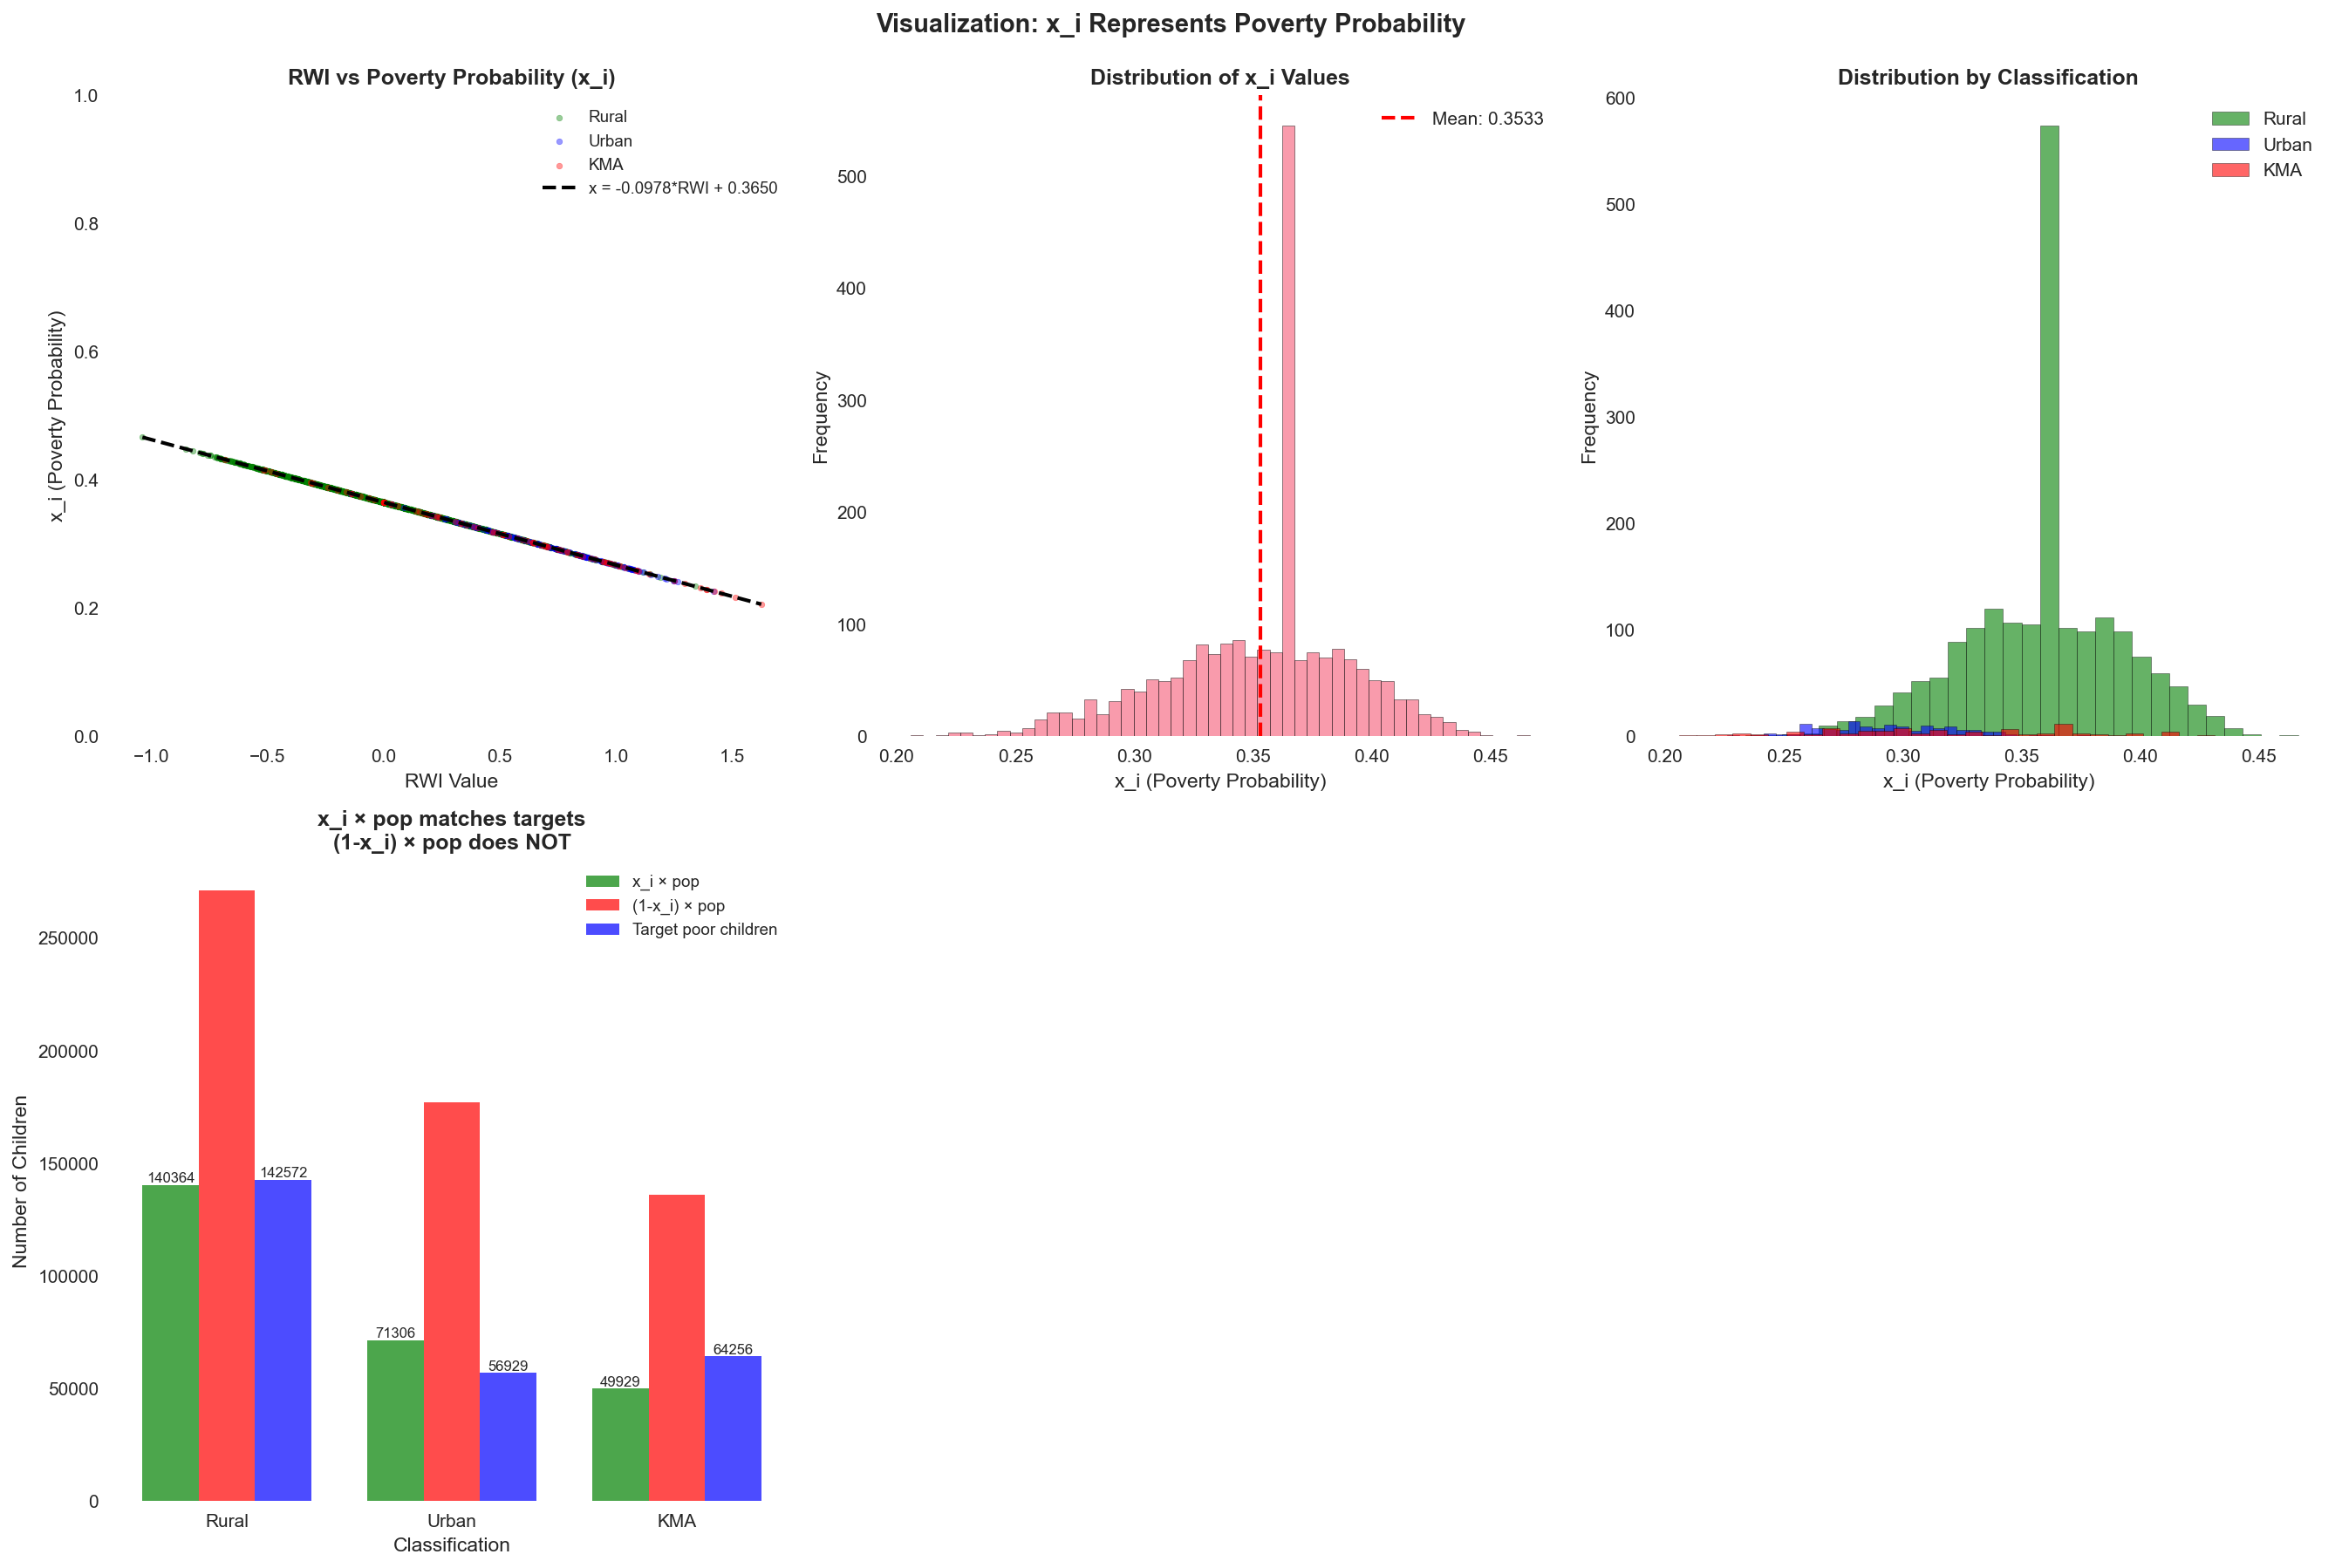

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')

sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. RWI vs x_i scatter plot
ax1 = plt.subplot(2, 3, 1)
for classification, color in zip(['Rural', 'Urban', 'KMA'], ['green', 'blue', 'red']):
    mask = gdf_tiles_with_admin['area_classification'] == classification
    if mask.sum() > 0:
        # Use x array directly (it's already calculated and aligned with gdf_tiles_with_admin)
        ax1.scatter(gdf_tiles_with_admin[mask]['rwi'], 
                   x[mask.values],
                   alpha=0.4, s=10, label=classification, color=color)

# Add linear fit line
rwi_range = np.linspace(gdf_tiles_with_admin['rwi'].min(), 
                        gdf_tiles_with_admin['rwi'].max(), 100)
x_i_line = sigma * rwi_range + mu
ax1.plot(rwi_range, x_i_line, 'k--', linewidth=2, 
        label=f'x = {sigma:.4f}*RWI + {mu:.4f}')
ax1.set_xlabel('RWI Value', fontsize=11)
ax1.set_ylabel('x_i (Poverty Probability)', fontsize=11)
ax1.set_title('RWI vs Poverty Probability (x_i)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Distribution of x_i values
ax2 = plt.subplot(2, 3, 2)
ax2.hist(x, bins=50, alpha=0.7, edgecolor='black')
ax2.axvline(x.mean(), color='r', linestyle='--', linewidth=2, 
           label=f'Mean: {x.mean():.4f}')
ax2.set_xlabel('x_i (Poverty Probability)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of x_i Values', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribution by classification
ax3 = plt.subplot(2, 3, 3)
for classification, color in zip(['Rural', 'Urban', 'KMA'], ['green', 'blue', 'red']):
    mask = gdf_tiles_with_admin['area_classification'] == classification
    if mask.sum() > 0:
        ax3.hist(x[mask.values], bins=30, alpha=0.6, 
                label=classification, edgecolor='black', color=color)
ax3.set_xlabel('x_i (Poverty Probability)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution by Classification', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. x_i * pop_i vs (1-x_i) * pop_i comparison
ax4 = plt.subplot(2, 3, 4)

# Calculate poor children using x_i * pop_i
poor_children_x_i = x * t

# Calculate "rich children" using (1-x_i) * pop_i (WRONG interpretation)
rich_children_wrong = (1 - x) * t

# Calculate by classification
comparison_data = []
for classification in ['Rural', 'Urban', 'KMA']:
    mask = gdf_tiles_with_admin['area_classification'] == classification
    if mask.sum() > 0:
        # Using x_i * pop_i (CORRECT)
        poor_x_i = poor_children_x_i[mask.values].sum()
        
        # Using (1-x_i) * pop_i (WRONG)
        rich_wrong = rich_children_wrong[mask.values].sum()
        
        # Target poor children
        if classification == 'Rural':
            target = POVERTY_RATE_RURAL * t[mask.values].sum()
        elif classification == 'Urban':
            target = POVERTY_RATE_URBAN * t[mask.values].sum()
        else:  # KMA
            target = POVERTY_RATE_KMA * t[mask.values].sum()
        
        comparison_data.append({
            'Classification': classification,
            'x_i × pop (correct)': poor_x_i,
            '(1-x_i) × pop (wrong)': rich_wrong,
            'Target poor children': target
        })

df_comparison = pd.DataFrame(comparison_data)
x_pos = np.arange(len(df_comparison))
width = 0.25

ax4.bar(x_pos - width, df_comparison['x_i × pop (correct)'], width, 
       label='x_i × pop', color='green', alpha=0.7)
ax4.bar(x_pos, df_comparison['(1-x_i) × pop (wrong)'], width, 
       label='(1-x_i) × pop', color='red', alpha=0.7)
ax4.bar(x_pos + width, df_comparison['Target poor children'], width, 
       label='Target poor children', color='blue', alpha=0.7)

ax4.set_xlabel('Classification', fontsize=11)
ax4.set_ylabel('Number of Children', fontsize=11)
ax4.set_title('x_i × pop matches targets\n(1-x_i) × pop does NOT', 
              fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(df_comparison['Classification'])
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, row in df_comparison.iterrows():
    ax4.text(i - width, row['x_i × pop (correct)'], 
            f'{row["x_i × pop (correct)"]:.0f}', 
            ha='center', va='bottom', fontsize=8)
    ax4.text(i + width, row['Target poor children'], 
            f'{row["Target poor children"]:.0f}', 
            ha='center', va='bottom', fontsize=8)


plt.suptitle('Visualization: x_i Represents Poverty Probability', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Alternative: Solve Using Linear Programming (OR-Tools)

In [15]:

from ortools.linear_solver import pywraplp

# Create the linear solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Decision variables: sigma and mu
sigma_var = solver.NumVar(-solver.infinity(), solver.infinity(), 'sigma')
mu_var = solver.NumVar(-solver.infinity(), solver.infinity(), 'mu')
    
# with 3 equality constraints and 2 variables, the system is overdetermined.
# minimize the sum of absolute deviations from the equality constraints,
# subject to bounds ensuring all x_i values stay in [0, 1].

# Create deviation variables for each constraint (to allow relaxation)
dev1_pos = solver.NumVar(0, solver.infinity(), 'dev1_pos')
dev1_neg = solver.NumVar(0, solver.infinity(), 'dev1_neg')
dev2_pos = solver.NumVar(0, solver.infinity(), 'dev2_pos')
dev2_neg = solver.NumVar(0, solver.infinity(), 'dev2_neg')
dev3_pos = solver.NumVar(0, solver.infinity(), 'dev3_pos')
dev3_neg = solver.NumVar(0, solver.infinity(), 'dev3_neg')

# Relaxed equality constraints with deviations
# sigma * W_j + mu * T_j + dev_j_pos - dev_j_neg = P_j * T_j
relaxed_constraint1 = solver.Constraint(P1 * T1, P1 * T1)
relaxed_constraint1.SetCoefficient(sigma_var, W1)
relaxed_constraint1.SetCoefficient(mu_var, T1)
relaxed_constraint1.SetCoefficient(dev1_pos, 1)
relaxed_constraint1.SetCoefficient(dev1_neg, -1)

relaxed_constraint2 = solver.Constraint(P2 * T2, P2 * T2)
relaxed_constraint2.SetCoefficient(sigma_var, W2)
relaxed_constraint2.SetCoefficient(mu_var, T2)
relaxed_constraint2.SetCoefficient(dev2_pos, 1)
relaxed_constraint2.SetCoefficient(dev2_neg, -1)

relaxed_constraint3 = solver.Constraint(P3 * T3, P3 * T3)
relaxed_constraint3.SetCoefficient(sigma_var, W3)
relaxed_constraint3.SetCoefficient(mu_var, T3)
relaxed_constraint3.SetCoefficient(dev3_pos, 1)
relaxed_constraint3.SetCoefficient(dev3_neg, -1)

# Add bounds constraints to ensure x_i = sigma * RWI_i + mu stays in [0, 1]
# Since x_i = sigma * RWI_i + mu is linear in RWI_i, the extreme values occur at endpoints.
# However, which endpoint gives min/max depends on the sign of sigma:
#   - If sigma > 0: min at RWI_min, max at RWI_max
#   - If sigma < 0: min at RWI_max, max at RWI_min
# To ensure ALL x_i are in [0, 1], we need constraints at both endpoints:
#   min(sigma * RWI_i + mu) >= 0  and  max(sigma * RWI_i + mu) <= 1

rwi_min = y.min()
rwi_max = y.max()

# Ensure minimum x_i >= 0: both endpoints must be >= 0
bound_lower_min = solver.Constraint(0, solver.infinity())
bound_lower_min.SetCoefficient(sigma_var, rwi_min)
bound_lower_min.SetCoefficient(mu_var, 1)

bound_lower_max = solver.Constraint(0, solver.infinity())
bound_lower_max.SetCoefficient(sigma_var, rwi_max)
bound_lower_max.SetCoefficient(mu_var, 1)

# Ensure maximum x_i <= 1: both endpoints must be <= 1
bound_upper_min = solver.Constraint(-solver.infinity(), 1)
bound_upper_min.SetCoefficient(sigma_var, rwi_min)
bound_upper_min.SetCoefficient(mu_var, 1)

bound_upper_max = solver.Constraint(-solver.infinity(), 1)
bound_upper_max.SetCoefficient(sigma_var, rwi_max)
bound_upper_max.SetCoefficient(mu_var, 1)

# Objective: Minimize sum of RELATIVE deviations (normalized by target values)
# This ensures all constraints are balanced, not just those with larger absolute targets
# Weight each deviation by 1/(target) so we minimize relative errors
target1 = P1 * T1
target2 = P2 * T2
target3 = P3 * T3

objective = solver.Objective()
objective.SetCoefficient(dev1_pos, 1.0 / target1)
objective.SetCoefficient(dev1_neg, 1.0 / target1)
objective.SetCoefficient(dev2_pos, 1.0 / target2)
objective.SetCoefficient(dev2_neg, 1.0 / target2)
objective.SetCoefficient(dev3_pos, 1.0 / target3)
objective.SetCoefficient(dev3_neg, 1.0 / target3)
objective.SetMinimization()

# Solve
print("Solving using OR-Tools Linear Programming solver...")
print(f"RWI range: [{rwi_min:.6f}, {rwi_max:.6f}]")
print(f"Constraints: 3 relaxed equality + 4 bounds (ensuring all x_i in [0,1])")
print(f"Objective: Minimize sum of RELATIVE deviations (weighted by 1/target)")
print()

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    sigma_lp = sigma_var.solution_value()
    mu_lp = mu_var.solution_value()
    
    print("Solution found!")
    print(f"  sigma (LP) = {sigma_lp:.6f}")
    print(f"  mu (LP) = {mu_lp:.6f}")
    print(f"  Objective value (weighted relative deviation) = {objective.Value():.6f}")
    print()
    
    # Calculate x_i values for LP solution
    x_lp = sigma_lp * y + mu_lp
    n_out_of_bounds_lp = np.sum((x_lp < 0) | (x_lp > 1))
    
    print("Bounds check for LP solution:")
    print(f"  Cells with x_i < 0: {np.sum(x_lp < 0)}")
    print(f"  Cells with x_i > 1: {np.sum(x_lp > 1)}")
    print(f"  Total out of bounds: {n_out_of_bounds_lp}/{len(x_lp)}")
    
    if n_out_of_bounds_lp == 0:
        print("All x_i values are within [0, 1]!")
    else:
        print(f"Warning: {n_out_of_bounds_lp} cells still out of bounds")
        print("   (Bounds constraints only enforced for min/max RWI)")
    
    # Check constraint satisfaction
    result1 = np.sum(x_lp[S1] * t[S1])
    result2 = np.sum(x_lp[S2] * t[S2])
    result3 = np.sum(x_lp[S3] * t[S3])
    
    target1 = P1 * T1
    target2 = P2 * T2
    target3 = P3 * T3
    
    print("\nConstraint satisfaction (LP solution):")
    print(f"  Rural: {result1:.2f} (target: {target1:.2f}, error: {result1 - target1:.2f}, rel error: {abs(result1 - target1)/target1*100:.2f}%)")
    print(f"  Urban: {result2:.2f} (target: {target2:.2f}, error: {result2 - target2:.2f}, rel error: {abs(result2 - target2)/target2*100:.2f}%)")
    print(f"  KMA:   {result3:.2f} (target: {target3:.2f}, error: {result3 - target3:.2f}, rel error: {abs(result3 - target3)/target3*100:.2f}%)")
    
    # Store LP solution for comparison
    sigma_lp_result = sigma_lp
    mu_lp_result = mu_lp
    use_lp_solution = True
    
elif status == pywraplp.Solver.FEASIBLE:
    print("Feasible solution found (may not be optimal)")
    sigma_lp = sigma_var.solution_value()
    mu_lp = mu_var.solution_value()
    sigma_lp_result = sigma_lp
    mu_lp_result = mu_lp
    use_lp_solution = True
    
else:
    print("No feasible solution found with LP constraints")
    print("   Falling back to least squares solution")
    use_lp_solution = False
    sigma_lp_result = None
    mu_lp_result = None

Solving using OR-Tools Linear Programming solver...
RWI range: [-1.037000, 1.626000]
Constraints: 3 relaxed equality + 4 bounds (ensuring all x_i in [0,1])
Objective: Minimize sum of RELATIVE deviations (weighted by 1/target)

Solution found!
  sigma (LP) = -0.212217
  mu (LP) = 0.398283
  Objective value (weighted relative deviation) = 0.452793

Bounds check for LP solution:
  Cells with x_i < 0: 0
  Cells with x_i > 1: 0
  Total out of bounds: 0/2224
All x_i values are within [0, 1]!

Constraint satisfaction (LP solution):
  Rural: 142571.93 (target: 142571.93, error: -0.00, rel error: 0.00%)
  Urban: 56929.17 (target: 56929.17, error: -0.00, rel error: 0.00%)
  KMA:   35161.23 (target: 64255.87, error: -29094.64, rel error: 45.28%)


### Compare Least Squares vs LP Solutions

In [16]:
# Compare the two solutions if LP solution is available
if 'sigma_lp_result' in locals() and sigma_lp_result is not None:
    print("="*70)
    print("COMPARISON: Least Squares vs Linear Programming")
    print("="*70)
    print(f"\nLeast Squares Solution:")
    print(f"  sigma = {sigma:.6f}")
    print(f"  mu = {mu:.6f}")
    
    print(f"\nLinear Programming Solution:")
    print(f"  sigma = {sigma_lp_result:.6f}")
    print(f"  mu = {mu_lp_result:.6f}")
    
    print(f"\nDifference:")
    print(f"  Δsigma = {abs(sigma - sigma_lp_result):.6f}")
    print(f"  Δmu = {abs(mu - mu_lp_result):.6f}")
    
    # Compare constraint satisfaction
    print(f"\nConstraint Satisfaction:")
    
    # Least squares
    x_ls = sigma * y + mu
    ls_rural = np.sum(x_ls[S1] * t[S1])
    ls_urban = np.sum(x_ls[S2] * t[S2])
    ls_kma = np.sum(x_ls[S3] * t[S3])
    
    # LP
    x_lp = sigma_lp_result * y + mu_lp_result
    lp_rural = np.sum(x_lp[S1] * t[S1])
    lp_urban = np.sum(x_lp[S2] * t[S2])
    lp_kma = np.sum(x_lp[S3] * t[S3])
    
    targets = [P1 * T1, P2 * T2, P3 * T3]
    labels = ['Rural', 'Urban', 'KMA']
    
    print(f"\n  {'Region':<10} {'Target':>15} {'LS Result':>15} {'LP Result':>15} {'LS Error':>12} {'LP Error':>12}")
    print(f"  {'-'*10} {'-'*15} {'-'*15} {'-'*15} {'-'*12} {'-'*12}")
    for label, target, ls_val, lp_val in zip(labels, targets, 
                                               [ls_rural, ls_urban, ls_kma],
                                               [lp_rural, lp_urban, lp_kma]):
        ls_err = abs(ls_val - target)
        lp_err = abs(lp_val - target)
        print(f"  {label:<10} {target:>15.2f} {ls_val:>15.2f} {lp_val:>15.2f} {ls_err:>12.2f} {lp_err:>12.2f}")
    
    # Bounds comparison
    ls_out = np.sum((x_ls < 0) | (x_ls > 1))
    lp_out = np.sum((x_lp < 0) | (x_lp > 1))

else:
    print("LP solution not available. Only least squares solution will be used.")

COMPARISON: Least Squares vs Linear Programming

Least Squares Solution:
  sigma = -0.097800
  mu = 0.364978

Linear Programming Solution:
  sigma = -0.212217
  mu = 0.398283

Difference:
  Δsigma = 0.114417
  Δmu = 0.033305

Constraint Satisfaction:

  Region              Target       LS Result       LP Result     LS Error     LP Error
  ---------- --------------- --------------- --------------- ------------ ------------
  Rural            142571.93       140364.38       142571.93      2207.55         0.00
  Urban             56929.17        71306.33        56929.17     14377.16         0.00
  KMA               64255.87        49929.16        35161.23     14326.71     29094.64
